<a href="https://colab.research.google.com/github/yvminyni/Bmix/blob/main/Bmix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Yi-Yun Lee Updated on November 30, 2023

# Load packages

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy import stats # Statistical functions

##-----packages for plot--------------------------------
import arviz as az # Exploratory analysis of Bayesian models
import matplotlib.pyplot as plt #plot

#-----packages for random sampling----------------------
import random # Generate random samples

In [2]:
import pymc as pm

# Load data

In [3]:
# Observation (cm/24h)
obs_g = [31.2]
# Ensemble forecast members
df_g = [31.0, 30.3, 14.4, 13.8, 17.9, 13.1, 17.1, 16.9, 20.7, 23.9, 20.0, 15.7, 18.6, 22.8, 14.6, 22.6, 19.6, 17.9, 13.5, 18.9]

In [4]:
print('Observation(cm/24h): ',obs_g) # cm
print('20 Ensemble members:',df_g) # cm

Observation(cm/24h):  [31.2]
20 Ensemble members: [31.0, 30.3, 14.4, 13.8, 17.9, 13.1, 17.1, 16.9, 20.7, 23.9, 20.0, 15.7, 18.6, 22.8, 14.6, 22.6, 19.6, 17.9, 13.5, 18.9]


## Asumption
<center>

$f_1(Y_N|𝐗_{fc})=∫g(Y_N|𝛉_{fc},𝐗_{fc})×π_{𝛉_{fc}}(𝛉_{fc}|𝐗_{fc})d𝛉_{fc}$


To get posterior distribution $π_{𝛉_{fc}}(𝛉_{fc}|𝐗_{fc})$:


Assume     
<center>

 $𝐗_{fc}|𝛉_{fc}\sim Gamma(𝛉_{fc}\equiv(α_{fc},β_{fc})$

Set prior distribution:
<center>

$𝛉_{fc}\sim π_{𝛉_{fc}}(·)$

## Set "Hyper-prior"  $π_{𝛉_{fc}}(·)$'s  parameters

Calculated based on historical observations of the area:

<center>

$μ_h = $ mean$(Y_h)=37.3$   

$σ^2_h = $ variance$(Y_h)=332.5$

Let
<center>

$ϕ_{fc}≡ α_{fc}×β_{fc} \sim TruncatedNormal(μ,σ^2)$

$\omega_{fc}≡ α_{fc}×β^2_{fc}\sim Gamma(α^*,β^*)$


And
<center>

$μ\approxμ_h$, &emsp; $σ^2=50$

$α^*×β^*\approx \sigma^2_h$, &emsp; $β^*=50$ 	&emsp;⇔ $α^*=\sigma^2_h/50$

In [5]:
prior_mean = 37.3 #cm
prior_var = 332.5 #cm

alpha_star=prior_var/50 # transformed prior variance to alpha^star

### Moreover, need to set weights for each model component:

<center>

$f_{Bmix}(Y_N|𝐗_{fc},Y_h,𝜆)≡λ×f_1(Y_N|𝐗_{fc})+(1-λ)×f_2(Y_N|Y_h)$

<center>

$λ=0.7$

In [6]:
# lambda: weight for f1 model component
lweight = 0.7 # 0.7*bmix(f1) + 0.3*bmix(f2)

# Start bulding Bayesian statistical model

Using gradient-based Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014).NUTS is a sampler for continuous variables based on Hamiltonian mechanics. It automatically tunes the step size and the number of steps per sample.

 See https://chi-feng.github.io/mcmc-demo/app.html?algorithm=NaiveNUTS&target=banana for a demonstration of NUTS sampling.

In [7]:
## Bayesian model
basic_model = pm.Model() # New Model object (container for the model random variables)
with basic_model:
  ##--------Stochastic random variables-----------------------------
  # Priors for the unknown model parameters
  theta = pm.TruncatedNormal("theta", mu=prior_mean, tau=0.02, lower=0) # tau=0.02 same as 1/(sigma^2=50)
  omega = pm.Gamma("omega",alpha= alpha_star, beta=0.02) # (=lambda=1/50=0.02) (same as beta_star=50)

  ##--------Transform the random variables----------------------------
  # Transformation from (theta and omega) to (alpha and beta1)
  alpha = pm.Deterministic("alpha", theta*theta/omega)
  beta1 = pm.Deterministic("beta1",theta/omega )   # (beta1 means 1/beta=lambda=theta/omega)

  #--------Distribution of forecast members X_fcst -----------------
  X_fcst = pm.Gamma("X_fcst", alpha=alpha, beta=beta1, observed=df_g) # (beta1=1/beta=lambda=theta/omega)

In [8]:
## Start sampling
with basic_model:
  trace = pm.sample(chains=4, draws=5000, tune=1000, random_seed=1234)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


If the user want to try other sampling algorithm   `dir(pm.step_methods)`
```python
## Sampling
## Use the slice sampling algorithm to sample parameters instead of NUTS(auto-selected)
with basic_model:
  step = pm.Slice() # Univariate slice sampler step method
  start = pm.find_MAP(model=basic_model) # Maximum a posteriori (MAP): the mode of the posterior distribution
  # draw 5000 posterior samples
  slice_idata = pm.sample(chains=4, draws=5000, step=step, start=start)
```

Graphical model provided by package

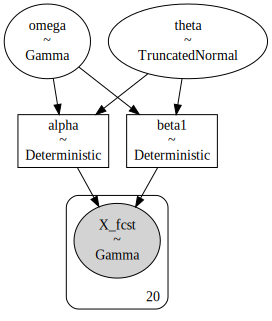

In [9]:
pm.model_to_graphviz(basic_model)

In [10]:
# Trace demonstration
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [11]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,22.75,2.46,18.36,27.41,0.04,0.03,5070.92,5956.24,1.0
omega,100.62,56.52,24.21,203.54,0.79,0.56,5316.82,8044.84,1.0
alpha,6.34,2.64,2.27,11.23,0.03,0.02,7744.26,11621.80,1.0
beta1,0.29,0.14,0.08,0.53,0.00,0.00,6075.12,9009.58,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


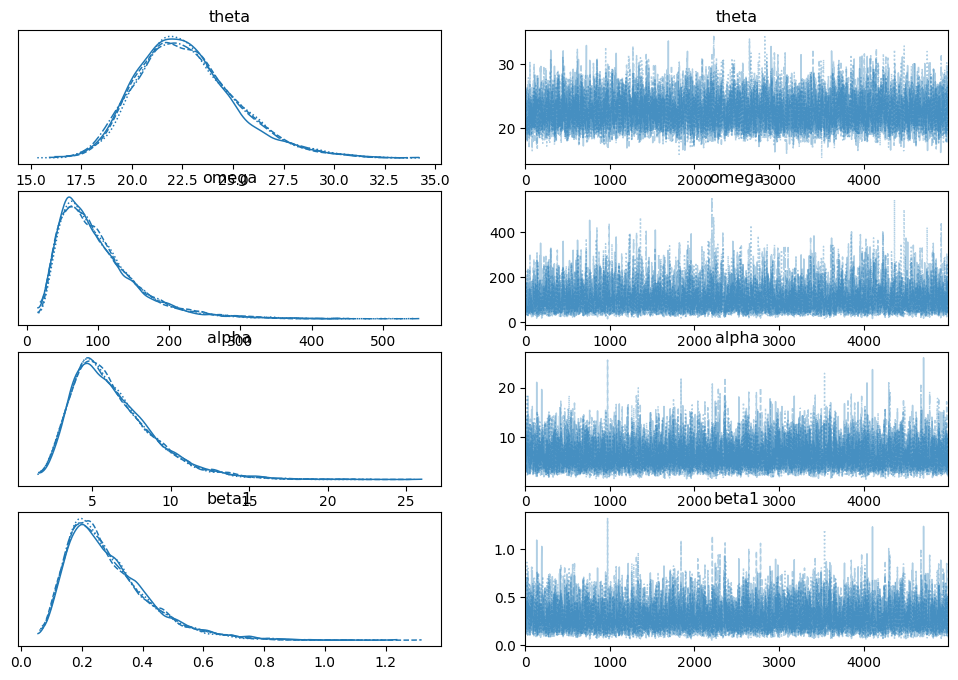

In [12]:
# Posterior plot
az.plot_trace(trace);

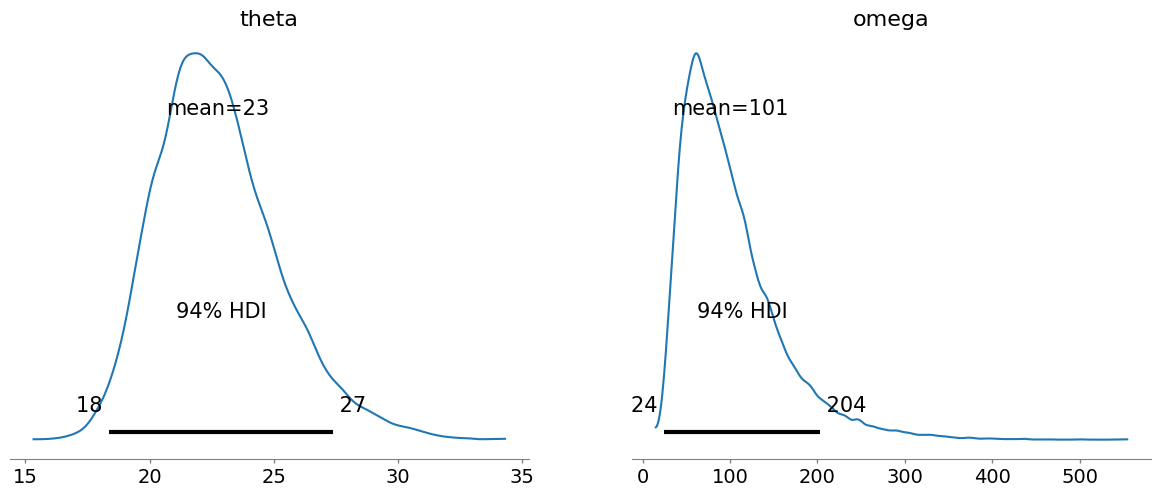

In [13]:
# Highest Posterior Density interval, HPD interval
az.plot_posterior(trace, var_names=["theta","omega"]); # provide posterior samples if needed

# Monte Carlo Integration

<center>

$\hat{f_1}(Y_N|𝐗_{fc})	\cong$  $\frac{1}{𝐈}$
$\sum_{i=1}^I g(Y_N|𝛉^{(i)}_{fc},𝐗_{fc})$

Define function

In [14]:
def bmix_f1_density(trace):
  x_pdf0=[0]*10000 # [0] array
  x = np.linspace(0, 100, 10000)
  count_i=0 # Counts of the posterior sample (alpha and beta)

  for j in range(0,len(trace.posterior["alpha"])): # jth chain
    for k in range(0,len(trace.posterior["alpha"][j])): # kth pair parameter(alpha^(k),beta^(k)) in jth chain
      # The kth sample in jth chain-----------
      alpha=trace.posterior["alpha"][j][k]
      beta1=trace.posterior["beta1"][j][k]
      # The kth posterior distrbution-------------
      distri = stats.gamma(loc=0, a=alpha, scale=1/beta1) # scale= 1/lambda
      x_pdf = distri.pdf(x)
      x_pdf0+=x_pdf
      count_i+=1

  x_post_f1=x_pdf0/count_i  # Average pdfs (posterior distribution)
  return x_post_f1 # Return approximated member-based PDF

# Bayesian mixture model (Bmix)

<center>

$f_{Bmix}(Y_N|𝐗_{fc},Y_h,𝜆)≡λ×f_1(Y_N|𝐗_{fc})+(1-λ)×f_2(Y_N|Y_h)$

In [15]:
n_sample= 10000
x = np.linspace(0, 100, 10000) # Define the range of precipitation [0,100] cm/24h
##=================================f1===========================================
# bmix f1 samples(rnsampl_f1) and density(bmix_f1_density_pdf)=============
x_pdf_f1 = bmix_f1_density(trace) # Function
distribution_f1 = x_pdf_f1/sum(x_pdf_f1) # Guarantee the sum to be 1
# Sampling
defined_f1 = stats.rv_discrete(values=(x,distribution_f1)) # Defined f1 distribution
rnsampl_f1 = defined_f1.rvs(size=n_sample)  # Generate random variates from f1

##=================================f2===========================================
beta_h = prior_var/prior_mean # (alpha * beta^2)/(alpha * beta)
alpha_h = prior_mean/beta_h  # (alpha * beta)/(beta)

# Gamma distribution
distri_hist = stats.gamma(loc=0, a=alpha_h, scale=beta_h)
x_pdf_hist = distri_hist.pdf(x)
distribution_h = x_pdf_hist/sum(x_pdf_hist)
# Sampling
defined_f2 = stats.rv_discrete(values=(x,distribution_h))
rnsampl_f2 = defined_f2.rvs(size=n_sample)  # Generate random variates from f2


##=================================mixture======================================
##----------------------------------weight--------------------------------------
# lweight:lambda=weight=0.7      # n_sample: total no. of samples
lsample_f1=round(lweight*n_sample) # no. of samples for f1 model
lsample_f2= n_sample - lsample_f1
# Combine samples from f1 and f2:  random.sample(population sequence, no. samples)
mixsamples = random.sample(list(rnsampl_f1), lsample_f1) + random.sample(list(rnsampl_f2) , lsample_f2)

##----------------------Fit density of Y_N Bmix model: bmix_pdf-----------
# Density function by using samples [non-parametric pdf]
x = np.linspace(0, 100, 10000)
nparam_density = stats.gaussian_kde(mixsamples) # Kernel density estimation: estimate the probability density function (PDF)
bmix_pdf=nparam_density(x)

For internal used to get the following plot

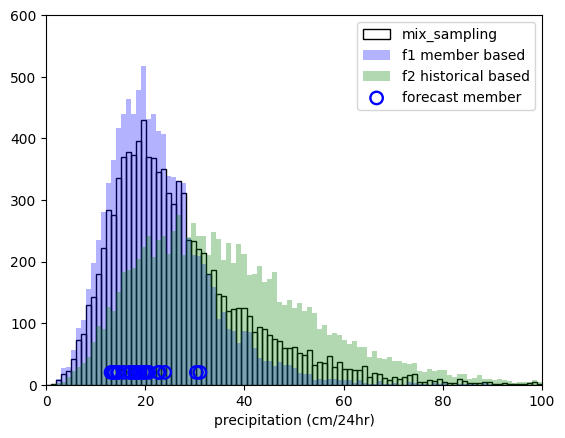

In [17]:
bins = np.linspace(0, 100, 100) # The edges of the bins.
plt.xlabel("precipitation (cm/24hr)")
plt.hist(mixsamples,bins,color='red',label='mix_sampling',edgecolor='black',linewidth=1,fill=False)
plt.hist(rnsampl_f1,bins,alpha=0.3,color='blue',label='f1 member based')
plt.hist(rnsampl_f2,bins,alpha=0.3,color='green',label='f2 historical based')

plt.scatter(df_g,np.repeat(20, len(df_g)),
           label = 'forecast member',s=80,facecolor='none',
           edgecolor ="blue",linewidths=1.7)
plt.ylim(0,600)
plt.xlim(0,100)
plt.legend(loc='upper right')

For internal used to get the following plot

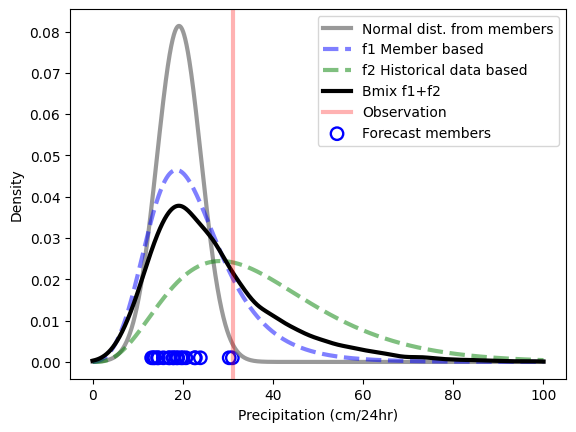

In [18]:
x = np.linspace(0, 100, 10000)

# Normal distribution asumption for ensemble forecast members
ens_mu=np.mean(df_g)
ens_sd=np.var(df_g)**(1/2)
norm_pdf=stats.norm.pdf(x,ens_mu,ens_sd)
plt.plot(x, norm_pdf,c='gray',linewidth=3,alpha=0.8,
         label ="Normal dist. from members")

# Bmix, f1, f2
plt.plot(x, x_pdf_f1,c='blue',linewidth=3, linestyle='dashed',alpha=0.5,
         label ="f1 Member based")
plt.plot(x, x_pdf_hist,c='green',linewidth=3,alpha=0.5,
         linestyle='dashed', label ="f2 Historical data based" )
plt.plot(x, bmix_pdf,c='black',linewidth=3,
         label ="Bmix f1+f2")

# Observations
plt.axvline(x = obs_g, color = 'r', alpha=0.3,
            label = 'Observation',linewidth=3)
# Ensemble forecast members
plt.scatter(df_g,np.repeat(0.001, len(df_g)),
           label = 'Forecast members',s=80,facecolor='none',
           edgecolor ="blue",linewidths=1.7)
plt.ylabel("Density")
plt.xlabel("Precipitation (cm/24hr)")
plt.legend()

```
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray
```

```
Last updated: Thu Nov 23 2023

Python implementation: CPython
Python version: 3.10.12
IPython version: 7.34.0

xarray: 2023.7.0

pandas: 1.5.3
scipy: 1.11.4
arviz: 0.15.1
numpy: 1.23.5
matplotlib: 3.7.1
pymc: 5.7.2

Watermark: 2.4.3
```

# Reference:

Introductory Overview of PyMC:

https://www.pymc.io/projects/docs/en/v5.10.0/learn/core_notebooks/pymc_overview.html

## Build model

* PYMC's distribution formula:
 https://www.pymc.io/projects/docs/en/latest/api/distributions.html#

* No-U-Turn Sampler (NUTS; Hoffman, 2014)
 http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf

* The Markov-chain Monte Carlo Interactive Gallery:
https://github.com/chi-feng/mcmc-demo#the-markov-chain-monte-carlo-interactive-gallery

